# Input prompt feature extraction

In [35]:
import pandas as pd
import numpy as np
from collections import Counter

import spacy 
import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns


## I) Preprocessing

### a) Data Loading task 1

In [2]:
generation_file_task1 = 'dataset/task1_merged_generation.jsonl'
eval_result_task1 = 'dataset/task1_merged_hallucination_scores.jsonl'


generation_task1_df = pd.read_json(generation_file_task1, lines=True)
evaluation_task1_df = pd.read_json(eval_result_task1, lines=True)

In [3]:
generation_task1_df

,title,h_score_cat,pageid,revid,description,categories,reference,prompt,answer,generation,run_id
0,Jan Willem Spruyt,0,16859978,1154166135,"Schoolteacher, South African civil servant, la...","[1826 births, 1908 deaths, 19th-century Dutch ...",Jan Willem Spruyt (4 July 1826 – 8 September 1...,What position did Jan Willem Spruyt hold in th...,Government secretary.,Jan Willem Spruyt served as the State Attorney...,task_1_run_1
1,HMS Prize,0,58453794,1102135374,German schooner captured and refitted as a Bri...,"[Q-ships of the Royal Navy, World War I naval ...",## Service as a Q ship First Prize underwent a...,What was the new name given to First Prize by ...,HMS Prize,"The vessel originally known as ""First Prize"" w...",task_1_run_1
2,Mississippi Highway 902,0,58127285,1061978358,Highway in Mississippi,"[State highways in Mississippi, Transportation...","Mississippi Highway 902 (MS 902, also known as...",What is the northern terminus of Mississippi H...,MS 35 in Lorena.,Mississippi Highway 902 (MS 902) does not have...,task_1_run_1
3,St. Elmo (1910 Thanhouser film),1,45082337,1168621248,None,"[1910 drama films, 1910 films, 1910s American ...",## Plot\n\nThe plot was adapted from Augusta J...,Who is betrothed to St. Elmo in the film?,Agnes,"In the 1985 film ""St. Elmo's Fire,"" there is n...",task_1_run_1
4,Oddfellows (album),1,37222693,1154749417,None,"[2013 albums, Ipecac Recordings albums, Tomaha...",## Release\n\nOddfellows was released on Janua...,What date was the album Oddfellows released?,"January 29, 2013","The album ""Oddfellows"" by Tomahawk was release...",task_1_run_1
...,...,...,...,...,...,...,...,...,...,...,...
1761,Sara Ramirez,7,1999305,1173275338,American actor and singer,"[1975 births, 20th-century American LGBT peopl...","## Personal life\n\nOn June 27, 2011, Ramírez ...",What organization did Sara Ramirez donate thei...,Locks of Love,"In September 2016, Sara Ramirez donated their ...",task_1_run_9
1762,Khalili Collection of Japanese Art,7,63416118,1153676727,Private collection of Meiji-era art,"[Japanese art collectors, Khalili Collections]",The Khalili Collection of Japanese Art is a pr...,What is the era of Japanese art featured in th...,Meiji-era (1868–1912),The Khalili Collection of Japanese Art feature...,task_1_run_9
1763,Jimmy Greaves,8,231068,1173499110,English footballer (1940–2021),"[1940 births, 1962 FIFA World Cup players, 196...","Greaves was fit to play in the final, but mana...",Who presented Jimmy Greaves with his World Cup...,Gordon Brown,Jimmy Greaves was presented with his World Cup...,task_1_run_9
1764,4X,8,705620,1168877758,Genre of strategy-based video and board games,"[4X games, Real-time strategy video games, Str...",### Complexity\n\n4X games are known for their...,What aspect of gameplay is prioritized over gr...,Gameplay,"In 4X games, gameplay tends to prioritize stra...",task_1_run_9


In [4]:
evaluation_task1_df

,run_id,halu_test_res
0,task_1_run_1,True
1,task_1_run_1,False
2,task_1_run_1,True
3,task_1_run_1,True
4,task_1_run_1,False
...,...,...
1761,task_1_run_9,False
1762,task_1_run_9,False
1763,task_1_run_9,False
1764,task_1_run_9,False


In [5]:
data_task1 = pd.concat([generation_task1_df, evaluation_task1_df], axis=1)
data_task1

,title,h_score_cat,pageid,revid,description,categories,reference,prompt,answer,generation,run_id,run_id,halu_test_res
0,Jan Willem Spruyt,0,16859978,1154166135,"Schoolteacher, South African civil servant, la...","[1826 births, 1908 deaths, 19th-century Dutch ...",Jan Willem Spruyt (4 July 1826 – 8 September 1...,What position did Jan Willem Spruyt hold in th...,Government secretary.,Jan Willem Spruyt served as the State Attorney...,task_1_run_1,task_1_run_1,True
1,HMS Prize,0,58453794,1102135374,German schooner captured and refitted as a Bri...,"[Q-ships of the Royal Navy, World War I naval ...",## Service as a Q ship First Prize underwent a...,What was the new name given to First Prize by ...,HMS Prize,"The vessel originally known as ""First Prize"" w...",task_1_run_1,task_1_run_1,False
2,Mississippi Highway 902,0,58127285,1061978358,Highway in Mississippi,"[State highways in Mississippi, Transportation...","Mississippi Highway 902 (MS 902, also known as...",What is the northern terminus of Mississippi H...,MS 35 in Lorena.,Mississippi Highway 902 (MS 902) does not have...,task_1_run_1,task_1_run_1,True
3,St. Elmo (1910 Thanhouser film),1,45082337,1168621248,None,"[1910 drama films, 1910 films, 1910s American ...",## Plot\n\nThe plot was adapted from Augusta J...,Who is betrothed to St. Elmo in the film?,Agnes,"In the 1985 film ""St. Elmo's Fire,"" there is n...",task_1_run_1,task_1_run_1,True
4,Oddfellows (album),1,37222693,1154749417,None,"[2013 albums, Ipecac Recordings albums, Tomaha...",## Release\n\nOddfellows was released on Janua...,What date was the album Oddfellows released?,"January 29, 2013","The album ""Oddfellows"" by Tomahawk was release...",task_1_run_1,task_1_run_1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,Sara Ramirez,7,1999305,1173275338,American actor and singer,"[1975 births, 20th-century American LGBT peopl...","## Personal life\n\nOn June 27, 2011, Ramírez ...",What organization did Sara Ramirez donate thei...,Locks of Love,"In September 2016, Sara Ramirez donated their ...",task_1_run_9,task_1_run_9,False
1762,Khalili Collection of Japanese Art,7,63416118,1153676727,Private collection of Meiji-era art,"[Japanese art collectors, Khalili Collections]",The Khalili Collection of Japanese Art is a pr...,What is the era of Japanese art featured in th...,Meiji-era (1868–1912),The Khalili Collection of Japanese Art feature...,task_1_run_9,task_1_run_9,False
1763,Jimmy Greaves,8,231068,1173499110,English footballer (1940–2021),"[1940 births, 1962 FIFA World Cup players, 196...","Greaves was fit to play in the final, but mana...",Who presented Jimmy Greaves with his World Cup...,Gordon Brown,Jimmy Greaves was presented with his World Cup...,task_1_run_9,task_1_run_9,False
1764,4X,8,705620,1168877758,Genre of strategy-based video and board games,"[4X games, Real-time strategy video games, Str...",### Complexity\n\n4X games are known for their...,What aspect of gameplay is prioritized over gr...,Gameplay,"In 4X games, gameplay tends to prioritize stra...",task_1_run_9,task_1_run_9,False


In [6]:
data_task1 = data_task1[['prompt', 'halu_test_res']]
data_task1

,prompt,halu_test_res
0,What position did Jan Willem Spruyt hold in th...,True
1,What was the new name given to First Prize by ...,False
2,What is the northern terminus of Mississippi H...,True
3,Who is betrothed to St. Elmo in the film?,True
4,What date was the album Oddfellows released?,False
...,...,...
1761,What organization did Sara Ramirez donate thei...,False
1762,What is the era of Japanese art featured in th...,False
1763,Who presented Jimmy Greaves with his World Cup...,False
1764,What aspect of gameplay is prioritized over gr...,False


### b) Data Loading task 3

In [7]:
generation_file_task3 = 'dataset/task3_merged_generation.jsonl'
eval_result_task3 = 'dataset/task3_merged_hallucination_scores.jsonl'


generation_task3_df = pd.read_json(generation_file_task3, lines=True)
evaluation_task3_df = pd.read_json(eval_result_task3, lines=True)

In [8]:
generation_task3_df

,prompt,name,type,generation,run_id,item_idx
0,I'm curious about the medicine bactocin gargle...,bactocin gargle,medicine,"Bactocin, often referred to in its generic for...",task_3_run_1,0
1,I'd like to learn more about the medicine gota...,gotam divicap,medicine,It seems there may be a typographical or trans...,task_3_run_1,1
2,Could you give me details about the medicine b...,bgmont-lc -kit,medicine,Bgmont-LC Kit is a medication commonly used fo...,task_3_run_1,2
3,What can you tell me about the medicine domici...,domicit cfc-free paste,medicine,Domicit CFC-Free Paste is a medication primari...,task_3_run_1,3
4,I'd like to learn more about the medicine drob...,drobest-m caplet,medicine,Drobest-M is a combination medication that typ...,task_3_run_1,4
...,...,...,...,...,...,...
2315,Can you share some details about the bacteria ...,Neptuniibacter balearica,bacteria,Neptuniibacter balearica is a species of bacte...,task_3_run_9,195
2316,I want to know more about the bacteria Limnoly...,Limnolyngbya fragilis,bacteria,**Limnolyngbya fragilis** is a species of cyan...,task_3_run_9,196
2317,What do you know about the bacteria Sacchariba...,Saccharibacillus naphthalenovorans,bacteria,**Saccharibacillus naphthalenovorans** is a sp...,task_3_run_9,197
2318,What do you know about the bacteria Grimontia ...,Grimontia fortis,bacteria,Grimontia fortis is a species of bacteria that...,task_3_run_9,198


In [9]:
evaluation_task3_df 

,model,false_acceptance_rate,refusal_rate,refusal_eval_raw,run_id,item_idx
0,gpt-4o-mini,0.825,0.175,True,task_3_run_1,0
1,gpt-4o-mini,0.825,0.175,True,task_3_run_1,1
2,gpt-4o-mini,0.825,0.175,False,task_3_run_1,2
3,gpt-4o-mini,0.825,0.175,False,task_3_run_1,3
4,gpt-4o-mini,0.825,0.175,False,task_3_run_1,4
...,...,...,...,...,...,...
2315,gpt-4o-mini,0.875,0.125,False,task_3_run_9,195
2316,gpt-4o-mini,0.875,0.125,False,task_3_run_9,196
2317,gpt-4o-mini,0.875,0.125,False,task_3_run_9,197
2318,gpt-4o-mini,0.875,0.125,False,task_3_run_9,198


In [10]:
data_task3 = pd.concat([generation_task3_df, evaluation_task3_df ], axis=1)
data_task3

,prompt,name,type,generation,run_id,item_idx,model,false_acceptance_rate,refusal_rate,refusal_eval_raw,run_id,item_idx
0,I'm curious about the medicine bactocin gargle...,bactocin gargle,medicine,"Bactocin, often referred to in its generic for...",task_3_run_1,0,gpt-4o-mini,0.825,0.175,True,task_3_run_1,0
1,I'd like to learn more about the medicine gota...,gotam divicap,medicine,It seems there may be a typographical or trans...,task_3_run_1,1,gpt-4o-mini,0.825,0.175,True,task_3_run_1,1
2,Could you give me details about the medicine b...,bgmont-lc -kit,medicine,Bgmont-LC Kit is a medication commonly used fo...,task_3_run_1,2,gpt-4o-mini,0.825,0.175,False,task_3_run_1,2
3,What can you tell me about the medicine domici...,domicit cfc-free paste,medicine,Domicit CFC-Free Paste is a medication primari...,task_3_run_1,3,gpt-4o-mini,0.825,0.175,False,task_3_run_1,3
4,I'd like to learn more about the medicine drob...,drobest-m caplet,medicine,Drobest-M is a combination medication that typ...,task_3_run_1,4,gpt-4o-mini,0.825,0.175,False,task_3_run_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Can you share some details about the bacteria ...,Neptuniibacter balearica,bacteria,Neptuniibacter balearica is a species of bacte...,task_3_run_9,195,gpt-4o-mini,0.875,0.125,False,task_3_run_9,195
2316,I want to know more about the bacteria Limnoly...,Limnolyngbya fragilis,bacteria,**Limnolyngbya fragilis** is a species of cyan...,task_3_run_9,196,gpt-4o-mini,0.875,0.125,False,task_3_run_9,196
2317,What do you know about the bacteria Sacchariba...,Saccharibacillus naphthalenovorans,bacteria,**Saccharibacillus naphthalenovorans** is a sp...,task_3_run_9,197,gpt-4o-mini,0.875,0.125,False,task_3_run_9,197
2318,What do you know about the bacteria Grimontia ...,Grimontia fortis,bacteria,Grimontia fortis is a species of bacteria that...,task_3_run_9,198,gpt-4o-mini,0.875,0.125,False,task_3_run_9,198


In [11]:
data_task3 = data_task3[['prompt', 'refusal_eval_raw']]
data_task3 = data_task3.rename(columns={'refusal_eval_raw': 'halu_test_res'})
data_task3

,prompt,halu_test_res
0,I'm curious about the medicine bactocin gargle...,True
1,I'd like to learn more about the medicine gota...,True
2,Could you give me details about the medicine b...,False
3,What can you tell me about the medicine domici...,False
4,I'd like to learn more about the medicine drob...,False
...,...,...
2315,Can you share some details about the bacteria ...,False
2316,I want to know more about the bacteria Limnoly...,False
2317,What do you know about the bacteria Sacchariba...,False
2318,What do you know about the bacteria Grimontia ...,False


In [12]:
dataset = pd.concat([data_task1, data_task3], axis=0, ignore_index=True)
dataset

,prompt,halu_test_res
0,What position did Jan Willem Spruyt hold in th...,True
1,What was the new name given to First Prize by ...,False
2,What is the northern terminus of Mississippi H...,True
3,Who is betrothed to St. Elmo in the film?,True
4,What date was the album Oddfellows released?,False
...,...,...
4081,Can you share some details about the bacteria ...,False
4082,I want to know more about the bacteria Limnoly...,False
4083,What do you know about the bacteria Sacchariba...,False
4084,What do you know about the bacteria Grimontia ...,False


## II) Text features extraction

### a) Spacy Analysis

In [13]:
prompt_df = dataset[['prompt']]
nlp = spacy.load("en_core_web_sm")

prompt_df

,prompt
0,What position did Jan Willem Spruyt hold in th...
1,What was the new name given to First Prize by ...
2,What is the northern terminus of Mississippi H...
3,Who is betrothed to St. Elmo in the film?
4,What date was the album Oddfellows released?
...,...
4081,Can you share some details about the bacteria ...
4082,I want to know more about the bacteria Limnoly...
4083,What do you know about the bacteria Sacchariba...
4084,What do you know about the bacteria Grimontia ...


In [14]:
def spacy_feature(doc):
    
    # ------------- token filter ------------- 
    non_punct_token = [t for t in doc if not t.is_punct and not t.is_space]                 #Token that are not punctuation or space
    words = [t for t in non_punct_token if t.is_alpha]                                      #Token that are alphabetic words
    lemma = [t.lemma_.lower() for t in words]                                               #Lemma words: normalized form of a word
    
    # ------------- bacic count ------------- 
    num_sents = sum(1 for _ in doc.sents)                                                   #Number of sentence
    num_token = len(doc)                                                                    #Number of tokens
    
    # ------------- Richess vocabulary ------------- 
    lemma_counts = Counter(lemma)
    lemma_ratio = len(lemma_counts) / num_token                                             #Lemma ratio
    
    # ------------- POS ratios ------------- 
    pos = Counter(t.pos_ for t in doc)
    noun_ratio = pos["NOUN"] / len(doc)
    verb_ratio = pos["VERB"] / len(doc)
    adj_ratio = pos["ADJ"] / len(doc)
    adv_ratio = pos["ADV"] / len(doc)
    aux_ratio = pos['AUX'] / len(doc)

    # ------------- Punctuations -------------    
    stop_ratio = np.mean([t.is_stop for t in doc]) if len(doc) else 0.0                     #Ratio stop words in the sentence  
    punct_ratio = np.mean([t.is_punct for t in doc]) if len(doc) else 0.0                   #Ratio punctuation in the sentence  
    
    # ------------- Recognized entity ------------- 
    entity_count = len(doc.ents)
    entity_ratio = entity_count / len(doc)                                                  #Ratio recognized entity in the sentence
    
    features = {
        'number sentence' : num_sents,
        'lemma ratio' : lemma_ratio, 
        'noun ratio' : noun_ratio, 
        'verb ratio' : verb_ratio, 
        'adjective ratio' : adj_ratio, 
        'adverb ratio' : adv_ratio, 
        'auxiliairis ratio' : aux_ratio, 
        'stop ratio' : stop_ratio, 
        'punctuation ratio' : punct_ratio, 
        'entity ratio' : entity_ratio}
    
    return features

In [15]:
docs = nlp.pipe(prompt_df["prompt"].tolist())

spacy_features_df = [spacy_feature(doc) for doc in docs]
features_df = pd.DataFrame(spacy_features_df)
df_with_spacy_features = pd.concat([prompt_df.reset_index(drop=True), features_df], axis=1)


df_with_spacy_features

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio
0,What position did Jan Willem Spruyt hold in th...,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647
1,What was the new name given to First Prize by ...,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846
2,What is the northern terminus of Mississippi H...,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000
3,Who is betrothed to St. Elmo in the film?,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000
4,What date was the album Oddfellows released?,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
4081,Can you share some details about the bacteria ...,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909
4082,I want to know more about the bacteria Limnoly...,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909
4083,What do you know about the bacteria Sacchariba...,1,0.900000,0.200000,0.100000,0.100000,0.0,0.100000,0.500000,0.100000,0.000000
4084,What do you know about the bacteria Grimontia ...,1,0.900000,0.200000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000


### b) TextStat Analysis

In [16]:
def textstat_feature(doc):
    # ------------- Readibility ------------- 
    flesch_score = textstat.flesch_reading_ease(doc)                        #flesh score
    us_school_grade = textstat.flesch_kincaid_grade(doc)                    #US School grade level  
    complexity = textstat.gunning_fog(doc)                                  #Complexity of the sentence
    
    # ------------- Words difficulty ------------- 
    nb_rare_words = textstat.difficult_words(doc)                           #Number difficulties words
    dale_chall_score = textstat.dale_chall_readability_score(doc)           #Dale CHall Score
    
    features = {
        'flesch score' : flesch_score,
        'grade (US School)' : us_school_grade,
        'complexity' : complexity,
        'Number rare words' : nb_rare_words,
        'Dale-Chall Score' : dale_chall_score
    }
    
    return features

In [17]:
docs = prompt_df["prompt"].tolist()

textstat_features_df = [textstat_feature(doc) for doc in docs]


textstat_features_df = pd.DataFrame(textstat_features_df)
df_with_textstat_features = pd.concat([df_with_spacy_features.reset_index(drop=True), textstat_features_df], axis=1)


df_with_textstat_features 

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score
0,What position did Jan Willem Spruyt hold in th...,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,79.557500,6.137500,8.900000,2,10.351350
1,What was the new name given to First Prize by ...,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,81.855000,4.823333,8.133333,1,5.547533
2,What is the northern terminus of Mississippi H...,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,47.300000,8.897778,12.488889,2,9.346233
3,Who is betrothed to St. Elmo in the film?,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,98.867500,0.587222,1.800000,2,9.123033
4,What date was the album Oddfellows released?,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,66.787143,5.682857,8.514286,3,10.750843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,Can you share some details about the bacteria ...,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,27.485000,11.910000,12.000000,4,10.448500
4082,I want to know more about the bacteria Limnoly...,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,44.405000,9.550000,12.000000,3,8.869500
4083,What do you know about the bacteria Sacchariba...,1,0.900000,0.200000,0.100000,0.100000,0.0,0.100000,0.500000,0.100000,0.000000,19.100000,12.831111,16.933333,3,9.346233
4084,What do you know about the bacteria Grimontia ...,1,0.900000,0.200000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,47.300000,8.897778,12.488889,3,9.346233


### c) Sentiment Analysis

In [18]:
def sentiment_analysis_feature(doc):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    features = sentiment_analyzer.polarity_scores(doc)
    
    rename_feature = {
        'negative sentiment' : features['neg'],
        'neutral sentiment' : features['neu'],
        'positive sentiment' : features['pos'],
        'overall sentiment' : features['compound']
    }
    return rename_feature

In [19]:
docs = prompt_df["prompt"].tolist()

sentiments_features_df = [sentiment_analysis_feature(doc) for doc in docs]


sentiments_features_df = pd.DataFrame(sentiments_features_df)
df_with_sentiment_features = pd.concat([df_with_textstat_features .reset_index(drop=True), sentiments_features_df], axis=1)


df_with_sentiment_features

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment
0,What position did Jan Willem Spruyt hold in th...,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,79.557500,6.137500,8.900000,2,10.351350,0.0,0.820,0.180,0.5106
1,What was the new name given to First Prize by ...,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,81.855000,4.823333,8.133333,1,5.547533,0.0,0.645,0.355,0.6705
2,What is the northern terminus of Mississippi H...,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,47.300000,8.897778,12.488889,2,9.346233,0.0,1.000,0.000,0.0000
3,Who is betrothed to St. Elmo in the film?,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,98.867500,0.587222,1.800000,2,9.123033,0.0,1.000,0.000,0.0000
4,What date was the album Oddfellows released?,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,66.787143,5.682857,8.514286,3,10.750843,0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,Can you share some details about the bacteria ...,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,27.485000,11.910000,12.000000,4,10.448500,0.0,0.804,0.196,0.2960
4082,I want to know more about the bacteria Limnoly...,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,44.405000,9.550000,12.000000,3,8.869500,0.0,0.874,0.126,0.0772
4083,What do you know about the bacteria Sacchariba...,1,0.900000,0.200000,0.100000,0.100000,0.0,0.100000,0.500000,0.100000,0.000000,19.100000,12.831111,16.933333,3,9.346233,0.0,1.000,0.000,0.0000
4084,What do you know about the bacteria Grimontia ...,1,0.900000,0.200000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,47.300000,8.897778,12.488889,3,9.346233,0.0,1.000,0.000,0.0000


### d) Semantic Embeddings

In [20]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')


In [21]:
prompts = prompt_df['prompt'].tolist()

emb_space = model.encode(
    prompts, 
    normalize_embeddings=True,
    batch_size=32,
    show_progress_bar=True
)

Batches:   0%|          | 0/128 [00:00<?, ?it/s]

In [22]:
emb_df = pd.DataFrame(emb_space, columns=[f"emb_{i}" for i in range(emb_space.shape[1])])
emb_df

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,0.043405,-0.023630,0.035623,0.025072,-0.028854,-0.057701,-0.025404,-0.001886,-0.010633,0.035597,...,0.020263,-0.034576,-0.020338,-0.010199,-0.043281,0.026619,0.002067,-0.005108,0.035830,0.005152
1,0.041249,-0.033728,0.002538,0.012175,-0.030766,-0.008950,-0.015661,0.038460,-0.067044,0.012801,...,-0.021324,-0.034448,0.020084,-0.016638,-0.002502,0.002741,0.001529,-0.040471,-0.017642,-0.020115
2,0.001771,0.011720,-0.005005,0.028706,-0.023435,-0.003917,-0.021397,-0.016277,0.017289,-0.036148,...,-0.052378,0.007740,-0.046305,0.002685,0.024000,-0.025461,-0.025561,-0.041382,-0.030143,-0.007269
3,0.043674,-0.002458,-0.026565,0.062082,0.024289,0.004653,-0.010440,-0.026457,0.000207,0.035236,...,0.005742,0.010826,-0.014209,0.029365,-0.028703,0.039712,-0.007366,0.005344,-0.019014,-0.001198
4,0.022959,-0.012580,-0.005607,0.004557,-0.034263,-0.007702,0.013897,-0.000150,-0.015286,0.038278,...,0.015265,0.007096,-0.009306,-0.043937,-0.003129,-0.022173,-0.048882,-0.037574,-0.010360,-0.024455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,0.015700,0.004079,-0.018124,-0.024108,-0.032327,0.001030,0.030902,-0.037538,-0.050545,-0.023353,...,-0.043734,-0.020333,0.033600,-0.063149,-0.037790,-0.012529,-0.026613,-0.027629,0.022544,-0.020907
4082,0.064004,-0.039327,0.002100,0.005243,-0.041932,-0.026201,0.061411,0.011031,-0.055143,0.002430,...,-0.026458,0.008076,0.038257,-0.033613,-0.045627,-0.086158,-0.005972,-0.031171,-0.002051,-0.040870
4083,0.028987,0.017837,-0.001511,-0.040241,-0.054750,-0.031854,0.053758,0.009400,0.005304,-0.020895,...,-0.051929,-0.034483,0.011247,-0.033767,-0.047275,-0.027966,-0.004350,-0.004946,0.015719,-0.028423
4084,0.020634,-0.003907,-0.004498,-0.002495,-0.030582,-0.016994,0.020834,0.019595,0.010184,-0.018317,...,-0.013269,-0.015469,0.006191,-0.051125,-0.044926,-0.006684,-0.012448,-0.005523,0.015520,-0.000936


### e) Hallucination output

In [23]:
hallucination_output = dataset['halu_test_res'].astype(int)
hallucination_output

0       1
1       0
2       1
3       1
4       0
       ..
4081    0
4082    0
4083    0
4084    0
4085    0
Name: halu_test_res, Length: 4086, dtype: int64

In [24]:
input_df = pd.concat([df_with_sentiment_features.reset_index(drop=True), hallucination_output], axis=1)

input_df = input_df.rename(columns={'halu_test_res' : 'hallucination score'})
input_df

,prompt,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,...,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment,hallucination score
0,What position did Jan Willem Spruyt hold in th...,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,...,79.557500,6.137500,8.900000,2,10.351350,0.0,0.820,0.180,0.5106,1
1,What was the new name given to First Prize by ...,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,...,81.855000,4.823333,8.133333,1,5.547533,0.0,0.645,0.355,0.6705,0
2,What is the northern terminus of Mississippi H...,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,...,47.300000,8.897778,12.488889,2,9.346233,0.0,1.000,0.000,0.0000,1
3,Who is betrothed to St. Elmo in the film?,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,...,98.867500,0.587222,1.800000,2,9.123033,0.0,1.000,0.000,0.0000,1
4,What date was the album Oddfellows released?,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,...,66.787143,5.682857,8.514286,3,10.750843,0.0,1.000,0.000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,Can you share some details about the bacteria ...,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,...,27.485000,11.910000,12.000000,4,10.448500,0.0,0.804,0.196,0.2960,0
4082,I want to know more about the bacteria Limnoly...,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,...,44.405000,9.550000,12.000000,3,8.869500,0.0,0.874,0.126,0.0772,0
4083,What do you know about the bacteria Sacchariba...,1,0.900000,0.200000,0.100000,0.100000,0.0,0.100000,0.500000,0.100000,...,19.100000,12.831111,16.933333,3,9.346233,0.0,1.000,0.000,0.0000,0
4084,What do you know about the bacteria Grimontia ...,1,0.900000,0.200000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,...,47.300000,8.897778,12.488889,3,9.346233,0.0,1.000,0.000,0.0000,0


In [ ]:
# input_df_embedding = pd.concat([emb_df.reset_index(drop=True), hallucination_output], axis=1)
# input_df_embedding

In [25]:
input_df = input_df.drop(columns={'prompt'})
input_df

,number sentence,lemma ratio,noun ratio,verb ratio,adjective ratio,adverb ratio,auxiliairis ratio,stop ratio,punctuation ratio,entity ratio,flesch score,grade (US School),complexity,Number rare words,Dale-Chall Score,negative sentiment,neutral sentiment,positive sentiment,overall sentiment,hallucination score
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,79.557500,6.137500,8.900000,2,10.351350,0.0,0.820,0.180,0.5106,1
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,81.855000,4.823333,8.133333,1,5.547533,0.0,0.645,0.355,0.6705,0
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,47.300000,8.897778,12.488889,2,9.346233,0.0,1.000,0.000,0.0000,1
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,98.867500,0.587222,1.800000,2,9.123033,0.0,1.000,0.000,0.0000,1
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,66.787143,5.682857,8.514286,3,10.750843,0.0,1.000,0.000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,27.485000,11.910000,12.000000,4,10.448500,0.0,0.804,0.196,0.2960,0
4082,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,44.405000,9.550000,12.000000,3,8.869500,0.0,0.874,0.126,0.0772,0
4083,1,0.900000,0.200000,0.100000,0.100000,0.0,0.100000,0.500000,0.100000,0.000000,19.100000,12.831111,16.933333,3,9.346233,0.0,1.000,0.000,0.0000,0
4084,1,0.900000,0.200000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,47.300000,8.897778,12.488889,3,9.346233,0.0,1.000,0.000,0.0000,0


## III) Training, validation, testing dataset

In [26]:
from sklearn.model_selection import train_test_split

X = input_df.drop(columns={'hallucination score'})
y = input_df['hallucination score']

#Training and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=524, stratify=y
)

#Validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=524, stratify=y_temp
)

#  Model Selection

## I) Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression


model_logistic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,      
    C=1.0,             
    max_iter=5000,
)

model_logistic.fit(X_train, y_train)

### a) Overfitting check

In [ ]:
y_val_pred = model_logistic.predict(X_val)
y_val_proba = model_logistic.predict_proba(X_val)[:, 1]


print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

model_logistic.fit(X_train_full, y_train_full)

y_test_pred = model_logistic.predict(X_test)
y_test_proba = model_logistic.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

In [ ]:
train_proba = model_logistic.predict_proba(X_train)[:, 1]
val_proba = model_logistic.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model_logistic, X_train, y_train, 
    cv=5, scoring="roc_auc")

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Val AUC')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model_logistic, X_train, y_train,
    cv=5, scoring="roc_auc"
)


print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


In [ ]:
from sklearn.metrics import log_loss

train_proba = model_logistic.predict_proba(X_train)
val_proba   = model_logistic.predict_proba(X_val)

train_logloss = log_loss(y_train, train_proba)
val_logloss   = log_loss(y_val, val_proba)

print("Train log loss:", train_logloss)
print("Validation log loss:", val_logloss)

### b) Features importances computed

In [ ]:
importance_logistic_regression = pd.Series(model_logistic.coef_[0], index=X.columns).sort_values(ascending=False)
importance_logistic_regression 

In [ ]:
plt.figure()
plt.barh(importance_logistic_regression.index, importance_logistic_regression.values)
plt.title('Feature importance Logistic regression')
plt.show()

## II) Correlation

In [ ]:
corr_matrix = input_df.corr()  
corr_matrix = corr_matrix['hallucination score']
corr_matrix = corr_matrix.drop(['hallucination score', 'number sentence'])
corr_matrix = corr_matrix.sort_values(ascending=False)
corr_matrix

In [ ]:
plt.figure()
plt.barh(corr_matrix.index, corr_matrix.values)
plt.title('Feature correlation with hallucination')
plt.show()

## III) Mutual Information

In [ ]:
mi = mutual_info_classif(X, y)
mi_df = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_df

In [ ]:
plt.figure()
plt.barh(mi_df.index, mi_df.values)
plt.title('Mutual Information between features and hallucination')
plt.show()

## IV) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,            
    min_samples_split=40,    
    min_samples_leaf=20,     
    max_features=0.3,        
    class_weight='balanced',
    random_state=524,
)
rf.fit(X_train, y_train)


### a) Check Overfitting and cross validation

In [ ]:
from sklearn.metrics import log_loss

train_loss = log_loss(y_train, rf.predict_proba(X_train))
val_loss   = log_loss(y_val,   rf.predict_proba(X_val))

print("Train log-loss:", train_loss)
print("Val log-loss  :", val_loss)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf,
    X,
    y,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [ ]:
train_proba = rf.predict_proba(X_train)[:, 1]
val_proba = rf.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

rf.fit(X_train_full, y_train_full)

y_test_pred = model_logistic.predict(X_test)
y_test_proba = model_logistic.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

 - Unstable model
 - No overfitting
 - cross validation is bad: the dataset is volatile

In [ ]:
feature_importance_rf = rf.feature_importances_

feature_names = X_train.columns


rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importance_rf
}).sort_values(by="importance", ascending=False)

rf_importance_df

In [ ]:
top_k = 20

plt.figure(figsize=(10, 6))
sns.barplot(
    data=rf_importance_df.head(top_k),
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## V) Xgboost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    reg_lambda=1,
    reg_alpha=1,
    
    objective="binary:logistic",
    random_state=524,
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)



### a) Overfitting check and cross validation

In [ ]:
train_pred_proba = xgb.predict_proba(X_train)
val_pred_proba   = xgb.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))


In [ ]:
from sklearn.model_selection import  StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    xgb,
    X, y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("CV Scores:", cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    xgb,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

Issue from the quality of the features and not the model

In [ ]:
train_proba = xgb.predict_proba(X_train)[:, 1]
val_proba = xgb.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

rf.fit(X_train_full, y_train_full)

y_test_pred = xgb.predict(X_test)
y_test_proba = xgb.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

In [ ]:
booster = xgb.get_booster()
importance_dict = booster.get_score(importance_type='gain')

xgb_imp = pd.Series(importance_dict)

xgb_imp = xgb_imp.sort_values(ascending=False)
print(xgb_imp)

In [ ]:
import shap

def xgb_predict(X):
    return xgb.predict_proba(X)[:, 1]

background = shap.kmeans(X_train, 100)

explainer = shap.KernelExplainer(xgb_predict, background)
shap_values = explainer.shap_values(X_train)  

shap.summary_plot(shap_values, X_train)

## VI) SVM with RBF Kernel

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
)

svm.fit(X_train, y_train)

In [ ]:
train_pred_proba = svm.predict_proba(X_train)
val_pred_proba   = svm.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))


In [ ]:
cv_scores = cross_val_score(
    svm, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    svm,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [ ]:
train_proba = svm.predict_proba(X_train)[:, 1]
val_proba = svm.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

svm.fit(X_train_full, y_train_full)

y_test_pred = xgb.predict(X_test)
y_test_proba = xgb.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

In [ ]:
def svm_predict(X):
    return svm.predict_proba(X)[:, 1]

background = shap.sample(X_train, 50, random_state=524).to_numpy()

explainer = shap.KernelExplainer(svm_predict, background)
X_sample = X_train.sample(300, random_state=524)
shap_values = explainer.shap_values(X_sample.to_numpy())
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns)


## VII) Multilayer Perceptron Classifier

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    learning_rate_init=0.001,
    alpha=1e-3,          
    max_iter=2000,
    early_stopping=True
)


mlp.fit(X_train, y_train)

,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True
,random_state,None


In [30]:
train_pred_proba = mlp.predict_proba(X_train)
val_pred_proba   = mlp.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))

Train log-loss: 0.6086811206170373
Val log-loss  : 0.6285914861082559


In [31]:
cv_scores = cross_val_score(
    mlp, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


[0.40464548 0.70257038 0.79681763 0.750306   0.59853121]
Mean: 0.6505741381941805
Std: 0.1394464650990974


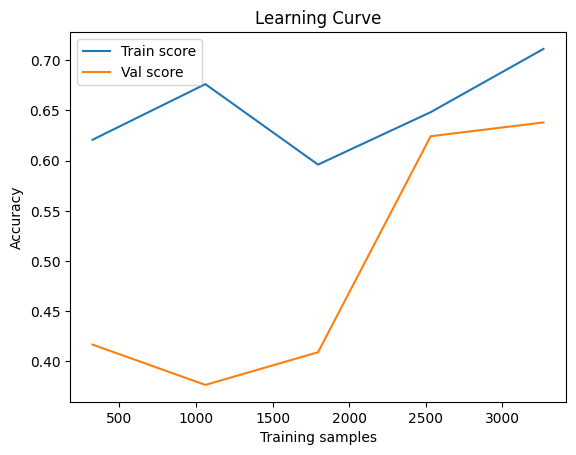

In [32]:
train_sizes, train_scores, val_scores = learning_curve(
    mlp,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [36]:
train_proba = mlp.predict_proba(X_train)[:, 1]
val_proba = mlp.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

Train ROC-AUC: 0.7215512163045814
Val ROC-AUC: 0.7019764374090248


In [39]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

mlp.fit(X_train_full, y_train_full)

y_test_pred = mlp.predict(X_test)
y_test_proba = mlp.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test ROC-AUC: 0.706360307496361
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       384
           1       0.65      0.36      0.46       229

    accuracy                           0.69       613
   macro avg       0.67      0.62      0.62       613
weighted avg       0.68      0.69      0.66       613



c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

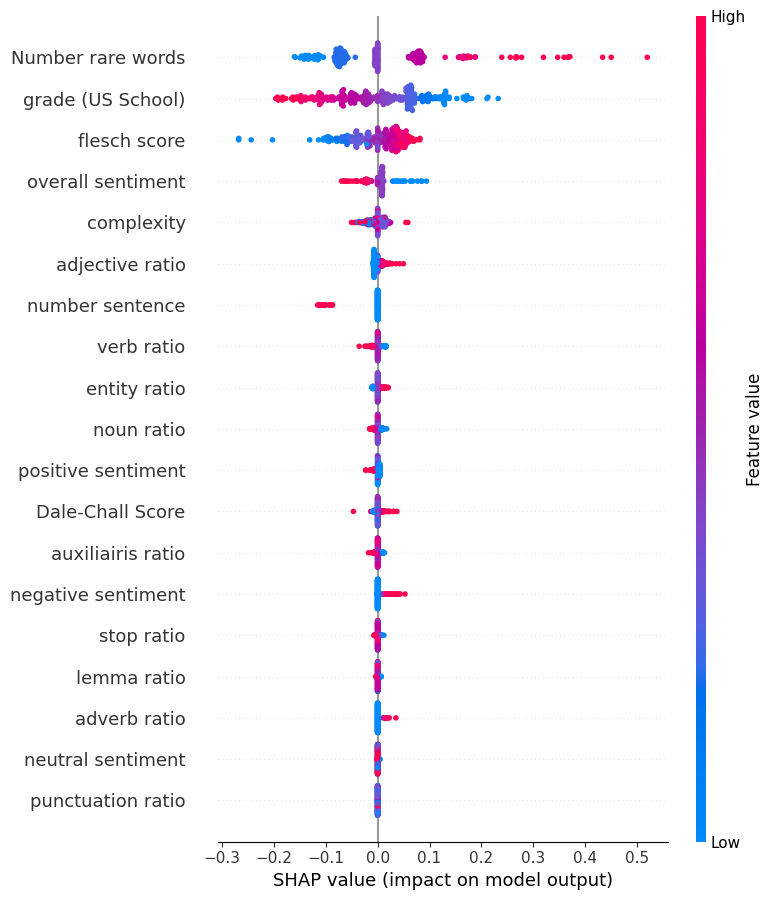

In [41]:
import shap


def mlp_predict(X):

    return mlp.predict_proba(X)[:, 1]


background = shap.kmeans(X_train, 50)

explainer = shap.KernelExplainer(mlp_predict, background)

X_sample = X_val.sample(300, random_state=524)

shap_values = explainer.shap_values(X_sample.to_numpy())

shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns)

In [42]:
pd.read_json('dataset/COT data/dataset_with_cot.jsonl', lines=True)

,id,source,context,question,cot_steps,answer,hallucination_label,hallucination_score,metadata
0,c24a93f6-c0f9-4b4c-93dc-48cecc2b3c00,NoisyWiki,Austroasiatic languages appear to be the extan...,Summarize the key information from this noisy ...,[Step 1: The text states that Austroasiatic la...,Austroasiatic languages are the original langu...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
1,f5452c98-6075-4c58-9582-ec68601cffcb,Wikipedia,Francisco d'Anconia is one of the central char...,What is the main idea of the following passage?,[step 1: The passage provides a summary of Fra...,The main idea is to describe Francisco d'Ancon...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
2,5a07302a-79f4-4e5a-8a6a-110b793f7c74,Wikipedia,The Angolan Armed Forces () or FAA is the mili...,What is the main idea of the following passage?,[step 1: The passage describes the structure a...,The main idea is to provide an overview of the...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
3,9864f98c-c0aa-438a-8bfc-64d4839bc2c1,ITIS,"After Bart makes his apology , the Parliament ...",What species or biological entity is described...,[Step 1: The text describes a situation involv...,No species or biological entity is described i...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
4,6575a994-8bf8-496d-81a3-2fd3fd85523d,Wikipedia,"In British Columbia, arraignment takes place i...",What is the main idea of the following passage?,[step 1: The passage describes a procedure in ...,The main idea is that arraignment in British C...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
...,...,...,...,...,...,...,...,...,...
995,24024018-5eb9-4353-af57-afba1ab58f2b,Wikipedia,"Bates wrote the words as a poem, originally en...",What is the main idea of the following passage?,[step 1: The passage discusses the origin of a...,The main idea is that Bates wrote a poem origi...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
996,ce0c627b-f3cd-4b20-8762-a7c777e5f688,Medicine,Histoplasma capsulatum is a dimorphic fungus t...,"H. capsulatum, a dimorphic fungus, is found in...",[Step 1: The context states that Histoplasma c...,"In tissue biopsies, H. capsulatum is present a...",NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
997,b333983d-809d-4145-a624-77a564f8d915,Wikipedia,"Ankara ( , ; ), historically known as Ancyra ...",What is the main idea of the following passage?,[step 1: The passage provides information abou...,The main idea is that Ankara is the capital an...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
998,23ea45ae-c00b-4f1d-823b-ff020145f4f8,Wikipedia,Albedo (; ) is the fraction of sunlight that i...,What is the main idea of the following passage?,[step 1: The passage defines albedo as the fra...,The main idea is to explain what albedo is and...,NO_HALLUCINATION,0.0,"{'model': 'gpt-4.1', 'temperature': 0.2, 'time..."
